# Approach 1

In [ ]:
# Importing modules
import numpy as np 
import pandas as pd
import keras

In [ ]:
# Reading in the data
data = pd.read_csv('../data/processed/stocks/nse_scraped/TCS.csv', 
                   thousands=',')

# Isolating the date and close price
data = data[['Date', 'Close']]
new_data = data.loc[:,:]
new_data.shape

In [ ]:
# Feature Pre Processing
new_data = new_data.drop(['Date'], axis = 1)
new_data = new_data.reset_index(drop = True)
T = new_data.values
T = T.astype('float32')
T = np.reshape(T, (-1, 1))

In [ ]:
# Min-max scaling to get the values in the range [0,1] to optimize convergence speed
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
T = scaler.fit_transform(T)


In [ ]:
# 80-20 split
train_size = int(len(T) * 0.80)
test_size = int(len(T) - train_size)
train, test = T[0:train_size,:], T[train_size:len(T),:]


In [ ]:
train.shape,test.shape

In [ ]:
# Method for create features from the time series data
def create_features(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        window = data[i:(i + window_size), 0]
        X.append(window)
        Y.append(data[i + window_size, 0])
    return np.array(X), np.array(Y)


In [ ]:
# Roughly one month of trading 
window_size = 7
X_train, Y_train = create_features(train, window_size)

X_test, Y_test = create_features(test, window_size)


In [ ]:
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

In [ ]:


# Reshape to the format of [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

T_shape = T.shape
train_shape = train.shape
test_shape = test.shape

# Make sure that the number of rows in the dataset = train rows + test rows
def isLeak(T_shape, train_shape, test_shape):
    return not(T_shape[0] == (train_shape[0] + test_shape[0]))

print(isLeak(T_shape, train_shape, test_shape))

# Model imports
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
""" from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout """

# Setting seed for reproducibility 
tf.random.set_seed(11)
np.random.seed(11)

# Building model
model = Sequential()

model.add(LSTM(units = 50, activation = 'relu', #return_sequences = True, 
               input_shape = (X_train.shape[1], window_size)))
model.add(Dropout(0.2))

# Optional additional model layer to make a deep network. If you want to use this, uncomment #return_sequences param in previous add
"""
model.add(LSTM(units = 25, activation = 'relu'))
model.add(Dropout(0.2))
"""

# Output layer
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')



history = model.fit(X_train, Y_train, epochs = 30, batch_size = 20, validation_data = (X_test, Y_test))

"""
Loading the best model and predicting
"""


# Predicting and inverse transforming the predictions

train_predict = model.predict(X_train)

Y_hat_train = scaler.inverse_transform(train_predict)

test_predict = model.predict(X_test)

Y_hat_test = scaler.inverse_transform(test_predict)

# Inverse transforming the actual values, to return them to their original values
Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

# Reshaping 
Y_hat_train = np.reshape(Y_hat_train, newshape =X_train.shape[0])
Y_hat_test = np.reshape(Y_hat_test, newshape = X_test.shape[0])

Y_train = np.reshape(Y_train, newshape = X_train.shape[0])
Y_test = np.reshape(Y_test, newshape = X_test.shape[0])

# Model performance evaluation
from sklearn.metrics import mean_squared_error

train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_hat_train))

test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_hat_test))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

In [ ]:
print(Y_test)

In [ ]:
import tensorflow as tf

print(tf.__version__)

# Approach 2

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [9]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    

def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [11]:
# Read in data
spy = pd.read_csv('../data/raw/stock/yahoo_finance/DRREDDY')

# Convert series into datetime type
spy['Date'] = pd.to_datetime(spy['Date'])

# Save target series
series = spy[['Close','Volume']]

# Create train data set
train_split_date = '2014-12-31'
train_split_index = np.where(spy.Date == train_split_date)[0][0]
x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2019-01-02'
test_split_index = np.where(spy.Date == test_split_date)[0][0]
x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

In [ ]:
spy.iloc[4755]

In [ ]:
series.head()

3768 3769 4755 4756 5558


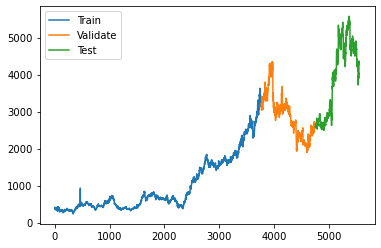

In [12]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [16]:
from sklearn.preprocessing import MinMaxScaler
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [ ]:
import tensorflow as tf

In [ ]:
keras = tf.keras
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 10
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

In [ ]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1, 0, 0.01])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")

In [ ]:
print(history.history["lr"])

In [ ]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 10
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=1e-4)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "saved_models", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=100,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

1/1 [==============================] - 1s 840ms/step - loss: 6.6635e-05 - mae: 0.0016 - accuracy: 0.0000e+00


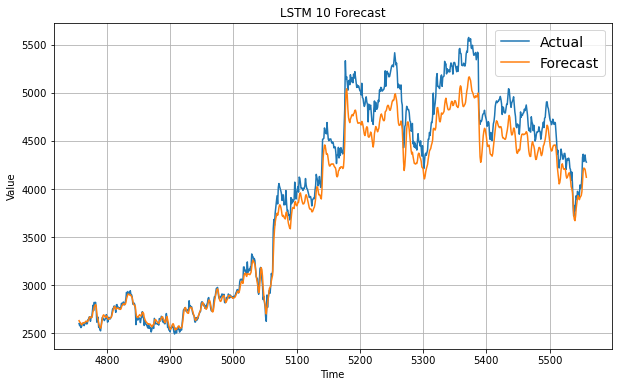

In [17]:
import numpy as np
import tensorflow as tf

model = tf.keras.models.load_model("../models/lstm_models/DRREDDY")

rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])

model.evaluate(normalized_x_test[np.newaxis,:], rnn_forecast)

rnn_forecast = rnn_forecast.flatten()

rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

plt.figure(figsize=(10,6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM 10 Forecast')
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

In [ ]:
print(x_test.index, rnn_unscaled_forecast)


In [ ]:
import tensorflow as tf

print(tf.__version__)

In [ ]:
model.evaluate(normalized_x_test[np.newaxis,:], )